In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='facemo.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('facemo.zip')
f.keys()
!unzip facemo.zip

In [2]:
gpus = tf.config.list_logical_devices('GPU') 
stg=tf.distribute.MirroredStrategy(gpus)

In [3]:
folder_path = "/content/facemo/images/" 
# folder_path = "../input/face-expression-recognition-dataset/images/"
# validation_folder_path = "../input/face-expression-recognition-dataset/images/"

In [4]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/facemo/images/train'
SIZE = (48,48) 
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 100

# get the total number of files to process
total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

# use tqdm to display a progress bar
with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            if file.endswith("jpg"):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1) # increment the progress bar
            else:
                continue


Processing Images: 100%|██████████| 2827/2827 [00:01<00:00, 1752.09it/s]


In [5]:
'''
expression = 'happy'
plt.style.use('dark_background')
plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)
    plt.imshow(img)  
plt.show()
'''

'\nexpression = \'happy\'\nplt.style.use(\'dark_background\')\nplt.figure(figsize=(12, 12))\nfor i in range(1, 10):\n    plt.subplot(3, 3, i)\n    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)\n    plt.imshow(img)  \nplt.show()\n'

In [6]:
batch_size = 32
picture_size = SIZE
datagen_train = ImageDataGenerator(rotation_range=.5, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    zoom_range=0.2, 
                                    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input 
                                )

datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input )

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=.5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(folder_path + 'train',
                                                    target_size=(picture_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_set = test_datagen.flow_from_directory(folder_path + 'validation',
                                                        target_size=(picture_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 2827 images belonging to 5 classes.
Found 797 images belonging to 5 classes.


In [24]:

from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


no_of_classes = 5

with stg.scope():
    base_model = tf.keras.applications.ResNet152V2(weights="imagenet",
                                            input_shape=(48, 48, 3),
                                            include_top=False,)
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(no_of_classes, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=['accuracy'])

model.summary()

234545216/234545216 [==============================] - 12s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2, 2, 2048)        58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                      

In [25]:
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                verbose=1,
                                restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)

callbacks = [early_stopping, lr_scheduler]


In [26]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=20,
                    validation_data=validation_set,
                    validation_steps=validation_set.n // batch_size,
                    callbacks=callbacks)

Epoch 1/20
88/88 [==============================] - 23s 132ms/step - loss: 1.2840 - accuracy: 0.5127 - val_loss: 0.8703 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 2/20
88/88 [==============================] - 7s 77ms/step - loss: 0.8547 - accuracy: 0.6834 - val_loss: 0.7725 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 3/20
88/88 [==============================] - 8s 88ms/step - loss: 0.6991 - accuracy: 0.7453 - val_loss: 0.6236 - val_accuracy: 0.7904 - lr: 0.0010
Epoch 4/20
88/88 [==============================] - 8s 96ms/step - loss: 0.6402 - accuracy: 0.7549 - val_loss: 0.4525 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 5/20
88/88 [==============================] - 7s 77ms/step - loss: 0.5207 - accuracy: 0.8093 - val_loss: 0.4289 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 6/20
88/88 [==============================] - 8s 87ms/step - loss: 0.4603 - accuracy: 0.8379 - val_loss: 0.4000 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 7/20
88/88 [==============================] - 8s 87ms/step - loss: 0

In [27]:
model.trainable = True

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

last_epoch = 20
# Fine-tune the model on your dataset
history = model.fit(train_generator, epochs=40, validation_data=validation_set, callbacks=[early_stopping,lr_scheduler], 
                    steps_per_epoch=len(train_generator), validation_steps=len(validation_set), 
                    class_weight=None, initial_epoch=last_epoch)

Epoch 21/40
89/89 [==============================] - 128s 255ms/step - loss: 1.2798 - accuracy: 0.4881 - val_loss: 8.5047 - val_accuracy: 0.2321 - lr: 0.0010
Epoch 22/40
89/89 [==============================] - 16s 182ms/step - loss: 0.7694 - accuracy: 0.7188 - val_loss: 3.6098 - val_accuracy: 0.5358 - lr: 0.0010
Epoch 23/40
89/89 [==============================] - 16s 175ms/step - loss: 0.6310 - accuracy: 0.7697 - val_loss: 10.5805 - val_accuracy: 0.4730 - lr: 0.0010
Epoch 24/40
89/89 [==============================] - ETA: 0s - loss: 0.5207 - accuracy: 0.8154
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
89/89 [==============================] - 17s 185ms/step - loss: 0.5207 - accuracy: 0.8154 - val_loss: 657.0613 - val_accuracy: 0.5044 - lr: 0.0010
Epoch 25/40
89/89 [==============================] - 16s 183ms/step - loss: 0.3303 - accuracy: 0.8833 - val_loss: 2.2261 - val_accuracy: 0.8896 - lr: 1.0000e-04
Epoch 26/40
89/89 [===========================

In [28]:
test_loss, test_acc = model.evaluate(validation_set)
print('Test accuracy:', test_acc)

25/25 [==============================] - 1s 39ms/step - loss: 0.1160 - accuracy: 0.9435
Test accuracy: 0.943538248538971


In [29]:
model.save('/kaggle/working/my_model_emo.h5')

0 = Angry
1 = Happy
2 = Neutral
3 = Sad
4 = Surprise
1/1 [==============================] - 3s 3s/step


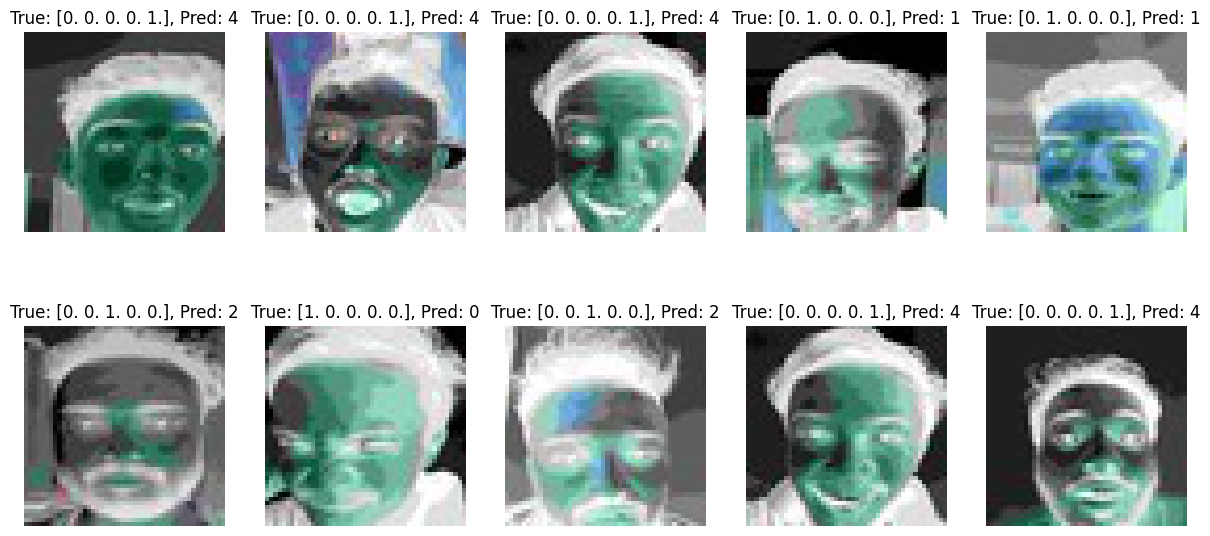

In [30]:
import numpy as np
import matplotlib.pyplot as plt
e = ['Angry','Happy','Neutral','Sad','Surprise']
for i in range(len(e)):
    print(i,"=",e[i])
# Get a batch of 10 random images from the test set
test_batch = validation_set.next()
images = test_batch[0][:10]
true_labels = test_batch[1][:10]

# Make predictions using the trained model
pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

# Plot the images with their true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
axs = axs.flatten()

for i in range(len(images)):
    # Rescale the pixel values from [0, 1] to [0, 255] and convert to integers
    img = (images[i] * 255).astype(np.uint8)
    # Invert the pixel values
    img = 255 - img
    axs[i].imshow(img)
    axs[i].set_title(f'True: {true_labels[i]}, Pred: {pred_labels[i]}')
    axs[i].axis('off')

plt.show()

